In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as scs
import math

In [3]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    """Helpful function to plot timeseries"""
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [4]:
def OSR2(predictions, train, test):
    sse = sum((test - predictions)**2)
    sst = sum((test - np.mean(train))**2)
    r2 = 1 - sse/sst
    
    return r2

In [5]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(1,3) # [1,2,3]
    for i in pq_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,0,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, 0, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: %6.5f | order: %s'%(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [6]:
df = pd.read_csv("AlphaMergedV2.csv")   # change dataset name
df.head()

,Unnamed: 0,timestamp,open,high,low,close,volume,EMA,RSI,MFI,name
0,0,2019-04-16,44.27,44.27,44.0900,44.19,169940,43.7109,69.2947,94.6821,DGRW
1,1,2019-04-15,44.12,44.14,43.9900,44.14,224939,43.6372,68.6777,89.6069,DGRW
2,2,2019-04-12,44.11,44.20,43.9500,44.06,199187,43.5598,67.7138,89.4954,DGRW
3,3,2019-04-11,43.90,43.92,43.7502,43.84,283355,43.4828,64.9605,81.6494,DGRW
4,4,2019-04-10,43.79,43.85,43.6500,43.85,182494,43.4279,65.1951,69.4415,DGRW


In [7]:
df2 = df[df['name'] == 'COST']
close = df2.close
time = df2.timestamp
df2 = pd.concat([close, time], axis = 1)

df2.set_index('timestamp', inplace = True)
df2.head()

,close
timestamp,
2019-04-16,245.34
2019-04-15,246.33
2019-04-12,241.95
2019-04-11,241.24
2019-04-10,245.61


In [8]:
#reverse
close = df2.iloc[::-1]
close.head()

,close
timestamp,
1998-01-23,43.38
1998-01-26,42.13
1998-01-27,43.56
1998-01-28,43.25
1998-01-29,43.44


In [9]:
# log returns
lrets = np.log(close['close']/close['close'].shift(1)).fillna(0)
lrets.head()
#lrets.index = pd.DatetimeIndex(lrets.index.values,freq=lrets.index.inferred_freq)

timestamp
1998-01-23    0.000000
1998-01-26   -0.029238
1998-01-27    0.033379
1998-01-28   -0.007142
1998-01-29    0.004383
Name: close, dtype: float64

In [10]:
train = lrets.iloc[:len(lrets) -  int(len(lrets)*0.15)  -1]
test = lrets.iloc[len(lrets) -  int(len(lrets)*0.15) :]
print(train.tail())
print(test.head())

timestamp
2016-02-02   -0.018349
2016-02-03   -0.012195
2016-02-04   -0.023589
2016-02-05    0.004943
2016-02-08    0.020825
Name: close, dtype: float64
timestamp
2016-02-10    0.000743
2016-02-11   -0.009501
2016-02-12    0.013546
2016-02-16    0.003090
2016-02-17    0.011999
Name: close, dtype: float64


Text(0,0.5,'1-day close price of train set')

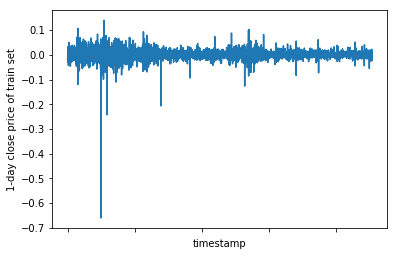

In [11]:
# is 1-day close price  stationary?
train.plot()
plt.ylabel('1-day close price of train set')

Text(0,0.5,'1-day close price of test set')

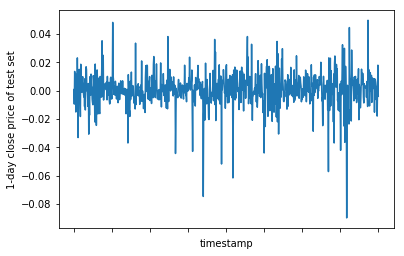

In [12]:
test.plot()
plt.ylabel('1-day close price of test set')

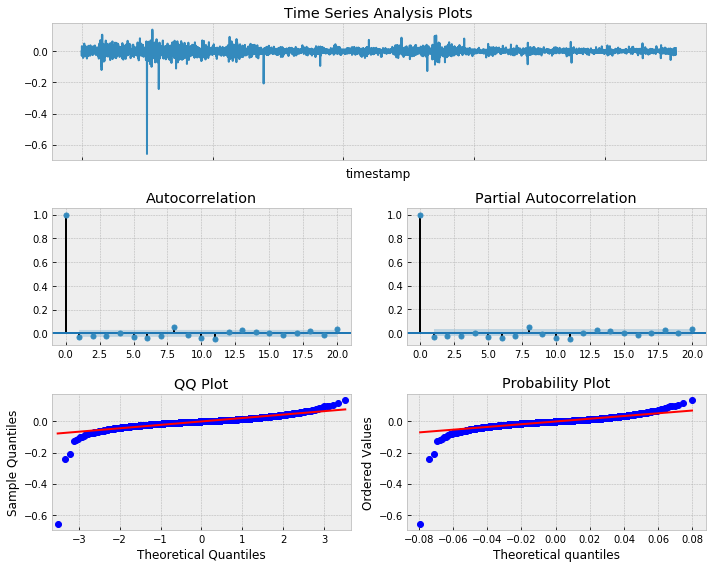

In [13]:
tsplot(train, lags=20)

In [14]:
# Augmented Dickey-Fuller unit root test
smt.adfuller(train, maxlag=20)
# first value is test statistic. Second value is the p-value
# p-value is small enough to reject the null-hypothesis that the TS is non-stationary

(-23.000136988377257,
 0.0,
 10,
 4529,
 {'1%': -3.4317946920312394,
  '5%': -2.862178383046203,
  '10%': -2.5671098145783207},
 -21690.284392736146)

### Fit Model

In [15]:
_get_best_model(train)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

aic: -21768.93144 | order: (1, 0, 1)


(-21768.93144394726,
 (1, 0, 1),
 <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x1c18687d30>)

In [16]:
arima101 = smt.ARIMA(train, (1,0,1)) #第一个AR， 第二个d，第三个MA  change parameters & model name
arima101_fit = arima101.fit(method='mle', trend='nc') #change model name*2
arima101_fit.summary() #change model name

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 4540
Model:                     ARMA(1, 1)   Log Likelihood               10887.466
Method:                           mle   S.D. of innovations              0.022
Date:                Sun, 28 Apr 2019   AIC                         -21768.931
Time:                        13:16:35   BIC                         -21749.669
Sample:                             0   HQIC                        -21762.147
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.close     0.7937      0.065     12.237      0.000       0.667       0.921
ma.L1.close    -0.8312      0.059    -14.070      0.000      -0.947      -0.715
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2598           +0.0000j            1.2598            0.0000
MA.1            1.2031           +0.0000j            1.2031            0.0000
-----------------------------------------------------------------------------
"""

### Analyze residuals

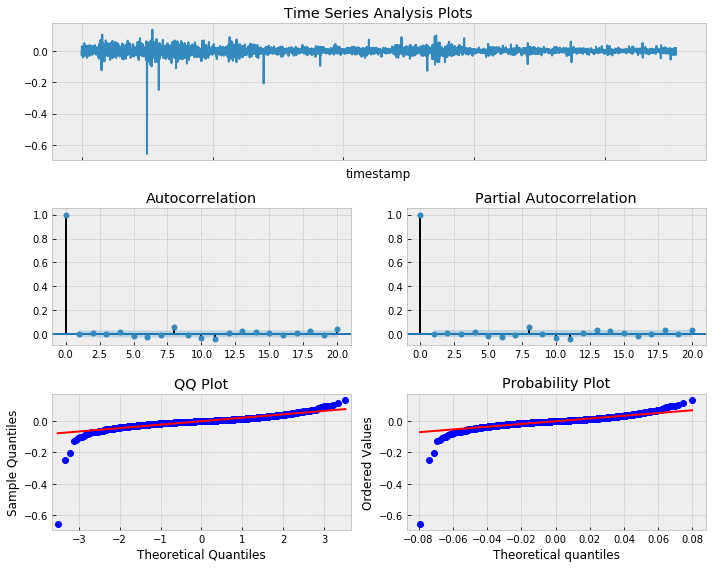

In [17]:
tsplot(arima101_fit.resid, lags=20) #change model name

### Test for remaining autocorrelation

In [18]:
# Ljung box test for remaining autocorrelation
sms.diagnostic.acorr_ljungbox(arima101_fit.resid, lags=(5,)) # or 10 lags       #change model name
#第二个是p-value  p值大于5%,序列为白噪声

(array([3.15609411]), array([0.67593506]))

### Forecasting

In [19]:
num_steps = 5
forecast_mean, forecast_std, forecast_ci = arima101_fit.forecast(steps=num_steps)   #change model name

In [20]:
arima101_fit.forecast(steps=num_steps)   #change model name

(array([2.36801624e-04, 1.87960736e-04, 1.49193395e-04, 1.18421909e-04,
        9.39971135e-05]),
 array([0.02199236, 0.02200778, 0.02201749, 0.02202361, 0.02202746]),
 array([[-0.04286744,  0.04334104],
        [-0.0429465 ,  0.04332242],
        [-0.0430043 ,  0.04330269],
        [-0.04304706,  0.0432839 ],
        [-0.04307904,  0.04326703]]))

In [27]:
train.values


array([ 0.        , -0.02923843,  0.03337922, ..., -0.02358893,
        0.00494309,  0.02082478])

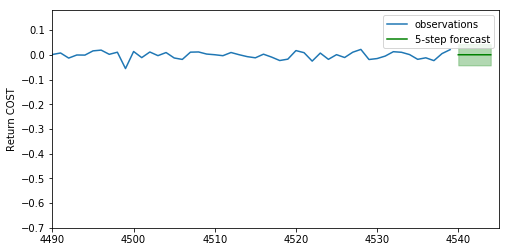

In [29]:
plt.figure(figsize=(8, 4))


plt.plot(train.values, label='observations')

forecast_steps = range(len(train), len(train) + num_steps)
plt.fill_between(forecast_steps, forecast_ci[:,0], forecast_ci[:,1], color='g', alpha=0.3)
plt.plot(forecast_steps, forecast_mean, label='5-step forecast', color='g')
plt.xlim([len(train) - 50, len(train) + num_steps])
plt.ylabel('Return COST')   #change stock name
plt.legend()

### Calculate the performance metrics on test set

In [ ]:
pred = []
for i in range( int(len(lrets)*0.15) ):
    moving_train = lrets.iloc[:len(lrets) -  int(len(lrets)*0.15)  -5 + i]
    moving_arima101 = smt.ARIMA(moving_train, (1,0,1))   #change model parameters  & model name
    moving_arima101_fit = moving_arima101.fit()   #change model name*2
    
    pred.append(moving_arima101_fit.forecast(steps=5)[0][4]) #change model name

len(pred)

In [ ]:
#(0,1,1)  final one
print( "OSR2 = " + str(OSR2(pred, train, test)))
print( "MAE = " + str(np.mean(abs(pred - test))))
print( "RMSE = " + str(math.sqrt(np.mean((pred - test)**2))))
print( "Scaled MAE = " + str(np.mean(abs(pred - test))/(max(test)-min(test))))
print( "Scaled RMSE = " + str(math.sqrt(np.mean((pred - test)**2))/(max(test)-min(test))))

# GARCH

In [30]:
from arch import arch_model

In [45]:
len(lrets)

5342

In [31]:
windowLength = 252
foreLength = len(lrets) - windowLength

In [43]:
#signal = 0*lrets[-foreLength:]
# create a rolling window by selecting the values between 1+d and k+d of S&P500 returns
TS = lrets[(1+2):(windowLength+2)] 
# Find the best ARIMA fit (we set differencing to 0 since we've already differenced the series once)
#res_tup = _get_best_model(TS)
order = (1,0,1)
model = arima101_fit
#now that we have our ARIMA fit, we feed this to GARCH model
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
out = res.forecast(horizon=1, start=None, align='origin')
signal.iloc[2] = np.sign(out.mean['h.1'].iloc[-1])

/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [64]:
signal = 0*lrets[-foreLength:]
for d in range(20): #foreLength
    # create a rolling window by selecting the values between 1+d and k+d of S&P500 returns
    TS = lrets[1:(windowLength+d)] 
    # Find the best ARIMA fit (we set differencing to 0 since we've already differenced the series once)
    #res_tup = _get_best_model(TS)
    order = (1,0,0)
    moving_arima100 = smt.ARIMA(TS, (1,0,0))  
    model = moving_arima100.fit()   
    #now that we have our ARIMA fit, we feed this to GARCH model
    p_ = order[0]
    o_ = order[1]
    q_ = order[2]

    am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')
    out = res.forecast(horizon=1, start=None, align='origin')
    signal.iloc[d] = out.mean['h.1'].iloc[-1] #np.sign

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind

In [65]:
signal

timestamp
1999-01-25   -0.000398
1999-01-26   -0.000469
1999-01-27   -0.000418
1999-01-28   -0.000501
1999-01-29   -0.000600
1999-02-01   -0.000601
1999-02-02   -0.000630
1999-02-03   -0.000582
1999-02-04   -0.000597
1999-02-05   -0.000627
1999-02-08   -0.000656
1999-02-09   -0.000668
1999-02-10   -0.000654
1999-02-11   -0.000704
1999-02-12   -0.000835
1999-02-16   -0.000783
1999-02-17   -0.000803
1999-02-18   -0.000765
1999-02-19   -0.000716
1999-02-22   -0.000727
1999-02-23    0.000000
1999-02-24   -0.000000
1999-02-25   -0.000000
1999-02-26   -0.000000
1999-03-01    0.000000
1999-03-02   -0.000000
1999-03-03    0.000000
1999-03-04    0.000000
1999-03-05    0.000000
1999-03-08   -0.000000
                ...   
2019-03-06   -0.000000
2019-03-07   -0.000000
2019-03-08    0.000000
2019-03-11    0.000000
2019-03-12    0.000000
2019-03-13    0.000000
2019-03-14   -0.000000
2019-03-15   -0.000000
2019-03-18    0.000000
2019-03-19    0.000000
2019-03-20   -0.000000
2019-03-21    0.000000
2

In [54]:
am = arch_model(arima101_fit.resid, p=1, o=0, q=1, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
out = res.forecast(horizon=1, start=None, align='origin')

/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [60]:
out.mean['h.1']

timestamp
1998-01-23         NaN
1998-01-26         NaN
1998-01-27         NaN
1998-01-28         NaN
1998-01-29         NaN
1998-01-30         NaN
1998-02-02         NaN
1998-02-03         NaN
1998-02-04         NaN
1998-02-05         NaN
1998-02-06         NaN
1998-02-09         NaN
1998-02-10         NaN
1998-02-11         NaN
1998-02-12         NaN
1998-02-13         NaN
1998-02-17         NaN
1998-02-18         NaN
1998-02-19         NaN
1998-02-20         NaN
1998-02-23         NaN
1998-02-24         NaN
1998-02-25         NaN
1998-02-26         NaN
1998-02-27         NaN
1998-03-02         NaN
1998-03-03         NaN
1998-03-04         NaN
1998-03-05         NaN
1998-03-06         NaN
                ...   
2015-12-24         NaN
2015-12-28         NaN
2015-12-29         NaN
2015-12-30         NaN
2015-12-31         NaN
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
2016-01-12         NaN
2